# Packages

In [ ]:
# Tensorflow Packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.utils import plot_model

# Basic Packages
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from numpy import ndarray
import pandas as pd

# Ignore warnings
warnings.filterwarnings("ignore")

# Useful Functions

In [ ]:
def normalize_data(data):



In [ ]:
def prepare_timeseries(data, target_column:str, lookback:int)->ndarray:
  """
  Description:
  ------------
  Prepare time series data with provided lookback period. The data will be shifted accordingly the provided lookback, and then NaN cells will be dropped for time series modelling.
  Parameters:
  ------------
  data(ndarray): The feature data to be used in time-series forecasting model
  target_column(str): The column that will be forecasted
  lookback(int): Number of lookback-periods the model should take into consideration
  Returns:
  ------------
  Returns whole Data (data) prepared in accordance with the provided lookback
  """

  data_copy = data.copy()
  for i in range(lookback):
    data_copy[f"target_column+{i+1}"] = data_copy[target_column].shift(periods=i+1)

  X = data_copy.dropna().drop([target_column], axis=1).astype(np.float32)
  y = data_copy.dropna()[target_column].astype(np.float32)

  return X,y

In [ ]:
def train_test_split(X:ndarray,y:ndarray,cut_off_rate:float):
  """
  Description:
  ------------
    Prepare data for training and set aside a certain percentage of the training data for later validation testing.

  Parameters:
  ------------
  X(ndarray): Pass feature data as numpy array
  y(ndarray): Pass target data as numpy array
  cut_off_rate(float): Cut off rate will be used to indexing up to a certain percentage of feature data

  Returns:
  ------------
  X and y values as both training and unseen validation data; X_train, X_test, y_train, y_test

  """
  cut_off = int(len(X)*cut_off_rate)
  X_train, y_train = X[:cut_off], y[:cut_off]
  X_test, y_test = X[cut_off:], y[cut_off:]

  return X_train, X_test, y_train, y_test

In [ ]:
def evaluate_preds(y_test:ndarray, y_pred:ndarray)->dict:
  """
  Description:
  ------------
  Evaluates the performance of predicted values against the true values using various metrics.

  Parameters:
  -----------
  y_test: array-like
      True values of the target variable.
  y_pred: array-like
      Predicted values of the target variable.

  Returns:
  --------
  dict:
      A dictionary containing the calculated metrics, including Mean Absolute Error (MAE),
      Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE).
  """
  y_test = tf.cast(y_test, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae=tf.keras.metrics.mean_absolute_error(y_test, y_pred)
  mse=tf.keras.metrics.mean_squared_error(y_test, y_pred)
  rmse=tf.sqrt(mse)
  mape=tf.keras.metrics.mean_absolute_percentage_error(y_test, y_pred)

  return {"mae":mae.numpy(),
          "mse":mse.numpy(),
          "rmse":rmse.numpy(),
          "mape":mape.numpy()}

In [ ]:
def predict_forward_window(prediction_data:ndarray, model_name):
  """
  Description:
  -----------
  Calculates the potential percentage change between last available close data and the predicted close.

  Parameters:
  -----------


  Returns
  -----------

  """

  prediction = tf.squeeze(model_name.predict(prediction_data))
  prediction = prediction.numpy()
  result = (prediction / prediction_data[0][1] -1 )*100

  # drowdown
  if result<0:
    print("Target Price: {:.3f}".format(prediction),
          "Potential Downside: {}".format(str(round(result,2))+"%"))

  # up-ward surge
  else:
    print("Target Price: {:.3f}".format(prediction),
    "Potential Upside: {}".format(str(round(result,2))+"%"))

# Callbacks

In [ ]:
tf.random.set_seed(42)

# best epoch
cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="checkpoints/model-{epoch:02d}-{root_mean_squared_error:.3f}.hdf5",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

# learning rate drop
cb_reducelr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    mode="min",
    factor=0.5, # reduce lr by 50% each rate drop
    patience=5,
    verbose=1,
    min_lr=0.000001
)

# early stopping
cb_earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    min_delta=0.001,
    patience=10,
    verbose=1,
)

# CSV logger
cb_csvlogger = tf.keras.callbacks.CSVLogger(
    filename="training_log.csv",
    separator=",",
    append=False
)

# Modelling For *Large Cap


In [ ]:
data = pd.read_csv("/content/ticker_dataframe (9).csv")
data.set_index("Date", inplace=True)
data = data[["Close","Volume"]]
data.head()

In [ ]:
X, y = prepare_timeseries(data, "Close", 7)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,0.8)

In [ ]:
inputs=layers.Input(shape=(8))
x=layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x=layers.BatchNormalization()(x)
x=layers.LSTM(512, activation="relu", return_sequences=True)(x)
x=layers.BatchNormalization()(x)
x=layers.Dropout(0.5)(x)
x=layers.LSTM(512)(x)
x=layers.BatchNormalization()(x)
x=layers.Dense(128, activation="relu")(x)
output = layers.Dense(1, activation="linear")(x)
lstm7d = tf.keras.Model(inputs=inputs, outputs=output, name="lstm7d") #7day look-back lstm model

# compile
lstm7d.compile(loss="mse",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=[tf.keras.metrics.RootMeanSquaredError()])

lstm7d.summary()

Model: "lstm7d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 8)]               0         
                                                                 
 lambda_5 (Lambda)           (None, 1, 8)              0         
                                                                 
 batch_normalization_15 (Bat  (None, 1, 8)             32        
 chNormalization)                                                
                                                                 
 lstm_10 (LSTM)              (None, 1, 512)            1067008   
                                                                 
 batch_normalization_16 (Bat  (None, 1, 512)           2048      
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 1, 512)            0    

In [ ]:
# Model fitting
lstm7d.fit(X_train, y_train,
             epochs=100,
             batch_size=128,
             verbose=0,
             validation_data=(X_test, y_test),
             callbacks=[cb_checkpoint,
                        cb_reducelr,
                        cb_earlystop,
                        cb_csvlogger])


Epoch 1: val_loss improved from inf to 53136.12891, saving model to checkpoints/model-01-122.490.hdf5

Epoch 2: val_loss improved from 53136.12891 to 49563.50781, saving model to checkpoints/model-02-88.491.hdf5

Epoch 3: val_loss improved from 49563.50781 to 47199.34375, saving model to checkpoints/model-03-52.958.hdf5

Epoch 4: val_loss improved from 47199.34375 to 47002.94141, saving model to checkpoints/model-04-30.150.hdf5

Epoch 5: val_loss did not improve from 47002.94141

Epoch 6: val_loss did not improve from 47002.94141

Epoch 7: val_loss improved from 47002.94141 to 46251.40625, saving model to checkpoints/model-07-21.325.hdf5

Epoch 8: val_loss did not improve from 46251.40625

Epoch 9: val_loss improved from 46251.40625 to 44754.03125, saving model to checkpoints/model-09-21.661.hdf5

Epoch 10: val_loss improved from 44754.03125 to 43264.11719, saving model to checkpoints/model-10-24.104.hdf5

Epoch 11: val_loss improved from 43264.11719 to 42381.91797, saving model to ch

In [ ]:
# load best model
best_lstm7d = tf.keras.models.load_model("/content/checkpoints/model-86-10.229.hdf5")
model_lstm_preds = tf.squeeze(best_lstm7d.predict(X[int(len(X)*0.8):]))
predictions = model_lstm_preds.numpy()

11/11 [==============================] - 1s 9ms/step


## Performance Evaluation
- Evaluation Scores
  - mae
  - mse
  - rmse
  - mape

- Actual vs Predictions
- Forward Prediction

In [ ]:
evaluate_preds(y_test, model_lstm_preds)

{'mae': 7.5996323, 'mse': 97.344215, 'rmse': 9.866317, 'mape': 3.476723}

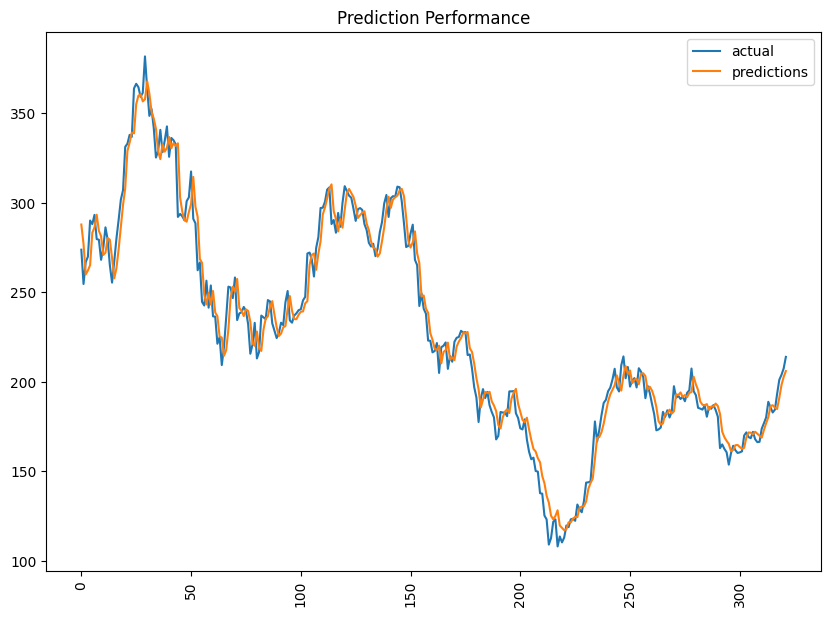

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(y[int(len(X)*0.8):].values, label="actual")
plt.plot(predictions, label="predictions")
plt.title("Prediction Performance")
plt.xticks(rotation=90)
plt.legend();

In [ ]:
test_data2 = [[47882200, 125.30, 124.25, 122.77, 120.58, 121.66, 120.11, 115.00]]
predict_forward_window(test_data2, best_lstm7d)

1/1 [==============================] - 0s 84ms/step
Target Price: 132.833 Potential Upside: 6.01%


# Modelling For *Low Cap

In [ ]:
data = pd.read_csv("/content/ticker_dataframe (10).csv")
data.set_index("Date", inplace=True)
data = data[["Close","Volume"]]
data.tail()

,Close,Volume
Date,,
2023-05-30 00:00:00-04:00,31.080000,169900
2023-05-31 00:00:00-04:00,31.719999,336000
2023-06-01 00:00:00-04:00,32.470001,95400
2023-06-02 00:00:00-04:00,33.680000,232800
2023-06-05 00:00:00-04:00,33.130001,209400


In [ ]:
X, y = prepare_timeseries(data, "Close", 7)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,0.8)

In [ ]:
inputs=layers.Input(shape=(8))
x=layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x=layers.BatchNormalization()(x)
x=layers.LSTM(512, activation="relu", return_sequences=True)(x)
x=layers.BatchNormalization()(x)
x=layers.Dropout(0.5)(x)
x=layers.LSTM(512)(x)
x=layers.BatchNormalization()(x)
x=layers.Dense(256, activation="relu")(x)
output = layers.Dense(1, activation="linear")(x)
lstm7d = tf.keras.Model(inputs=inputs, outputs=output, name="lstm7d") #7day look-back lstm model


# compile
lstm7d.compile(loss="mse",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=[tf.keras.metrics.RootMeanSquaredError()])

lstm7d.summary()

Model: "lstm7d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 8)]               0         
                                                                 
 lambda_2 (Lambda)           (None, 1, 8)              0         
                                                                 
 batch_normalization_6 (Batc  (None, 1, 8)             32        
 hNormalization)                                                 
                                                                 
 lstm_4 (LSTM)               (None, 1, 512)            1067008   
                                                                 
 batch_normalization_7 (Batc  (None, 1, 512)           2048      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 1, 512)            0    

In [ ]:
# Model fitting
lstm7d.fit(X_train, y_train,
             epochs=100,
             batch_size=128,
             verbose=0,
             validation_data=(X_test, y_test),
             callbacks=[cb_checkpoint,
                        cb_reducelr,
                        cb_earlystop,
                        cb_csvlogger])


Epoch 1: val_loss did not improve from 8.70386

Epoch 2: val_loss did not improve from 8.70386

Epoch 3: val_loss did not improve from 8.70386

Epoch 4: val_loss did not improve from 8.70386

Epoch 5: val_loss did not improve from 8.70386

Epoch 6: val_loss did not improve from 8.70386

Epoch 7: val_loss did not improve from 8.70386

Epoch 8: val_loss did not improve from 8.70386

Epoch 9: val_loss did not improve from 8.70386

Epoch 10: val_loss did not improve from 8.70386

Epoch 11: val_loss did not improve from 8.70386

Epoch 12: val_loss did not improve from 8.70386

Epoch 13: val_loss did not improve from 8.70386

Epoch 14: val_loss did not improve from 8.70386

Epoch 15: val_loss did not improve from 8.70386

Epoch 16: val_loss did not improve from 8.70386

Epoch 17: val_loss did not improve from 8.70386

Epoch 18: val_loss did not improve from 8.70386

Epoch 19: val_loss did not improve from 8.70386

Epoch 20: val_loss did not improve from 8.70386

Epoch 21: val_loss did not i

In [ ]:
# load best model
best_lstm7d_low = tf.keras.models.load_model("/content/checkpoints/model-60-2.036.hdf5")
model_lstm_preds = tf.squeeze(best_lstm7d_low.predict(X[int(len(X)*0.8):]))
predictions = model_lstm_preds.numpy()

17/17 [==============================] - 1s 10ms/step


## Performance Evaluation

In [ ]:
evaluate_preds(y_test, model_lstm_preds)

{'mae': 1.7807158, 'mse': 6.2048717, 'rmse': 2.490958, 'mape': 2.6025572}

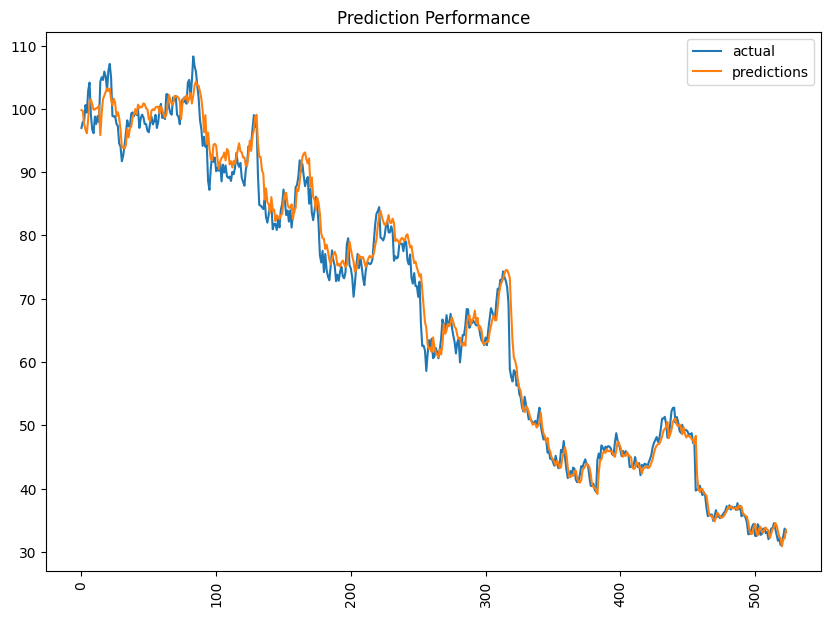

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(y[int(len(X)*0.8):].values, label="actual")
plt.plot(predictions, label="predictions")
plt.title("Prediction Performance")
plt.xticks(rotation=90)
plt.legend();

In [ ]:
test_data2 = [[209400, 33.13, 33.68, 32.47, 31.72, 31.08, 32.16, 31.76]]
predict_forward_window(test_data2, best_lstm7d_low)

1/1 [==============================] - 0s 200ms/step
Target Price: 33.573 Potential Upside: 1.34%


|Model|RMSE|MSE|MAE|MAPE|
|-----|----|---|---|----|
| Low Cap| 2.4909| 6.2048| 1.7807| 2.602|
| Large Cap| 9.8663| 97.344| 7.5996| 3.4767|